In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 25 21:09:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=d1707134f56a80adbe726de1e2d55bf0fba8a409e8d9326c4181661da082970b
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [5]:
pip install pydicom

     |████████████████████████████████| 1.9MB 8.0MB/s 


In [6]:
pip install albumentations

     |████████████████████████████████| 634kB 7.5MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=172eefdd4327b5f051258f0efc8144063cf89c47bc6978a80ec9051b1600b530
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [7]:
import time
import csv
import os
import copy
import re
import shutil
import pydicom
import pytesseract
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import albumentations as A
from albumentations.pytorch import ToTensor
from scipy import interp

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
class ImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform         
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx,0]
    data = pydicom.dcmread(img_name) # read dicom file
    arr = data.pixel_array # read image into pixel data
    shape = arr.shape
    if len(shape) == 4:
      arr = arr[0,:,:,0] # get the first slide of image
    elif len(shape) == 3:
      arr = arr[:,:,0] # get the first slide of image
    else:
      arr = arr
    image = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)

    labels = np.array(self.df.drop(['image_name'],axis=1))
    label = labels[idx]

    if self.transform:
      image = self.transform(image=image)["image"]
    
    return image, label

In [10]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Data_testing/file_names.csv")

means=(0.485, 0.456, 0.406)
stds=(0.229, 0.224, 0.225)

albumentation_train_transform = A.Compose([
                                      A.Resize(256,256),
                                      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                                      A.RandomCrop(height=224, width=224),
                                      A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                                      A.RandomBrightnessContrast(p=0.5),
                                      A.Normalize(mean=means, std=stds),
                                      ToTensor(),
                                    ])
albumentation_val_transform = A.Compose([
                                      A.Resize(256,256),
                                      A.CenterCrop(height=224, width=224),
                                      A.Normalize(mean=means, std=stds),
                                      ToTensor(),
                                  ])

(train_df, val_df) = train_test_split(df, test_size = 0.4)
(val_df, test_df) = train_test_split(val_df, test_size = 0.5)

train_dataset = ImageDataset(train_df, transform=albumentation_train_transform)
val_dataset = ImageDataset(val_df, transform=albumentation_val_transform)
test_dataset = ImageDataset(test_df, transform=albumentation_val_transform)

batch_num = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_num//4, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_num//4, shuffle=False, num_workers=2, pin_memory=True)

In [11]:
class MultiLabelVGG(nn.Module):
  def __init__(self):
    super(MultiLabelVGG, self).__init__()
    self.vgg16 = models.vgg16(pretrained=True) 
    self.linear = nn.Linear(1000, 4)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.vgg16(x)
    x = self.relu(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    
    return x

In [12]:
def calculate_metric(pred, label):
  return {
      "micro_f1":f1_score(y_true=label, y_pred=pred, average='micro'),
      "macro_f1":f1_score(y_true=label, y_pred=pred, average='macro'),
  }

In [13]:
def train_model(train_dataloader, val_dataloader, optimizer, criterion, net, threshold, num_epochs):
  since = time.time()

  tot_train_loss = []
  tot_val_loss = []

  tot_train_acc = []
  tot_val_acc = []
  
  for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch, num_epochs-1))
    print('-' * 10)

    net.train()
    
    train_running_loss = 0.0
    train_loss_values = []

    train_outputs = []
    train_labels = []

    for idx, data in enumerate(train_dataloader):
      img, label = data
      img = img.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      outputs = net(img)
      loss = criterion(outputs, label.type(torch.float))

      pred = outputs.data > threshold
      pred = pred.type(torch.float)

      loss.backward()
      optimizer.step()
      
      train_loss_values.append(loss.item())
      train_running_loss += loss.item()

      train_outputs.extend(pred.cpu().to(torch.int).numpy())
      train_labels.extend(label.cpu().to(torch.int).numpy())

    train_result = calculate_metric(np.array(train_outputs), np.array(train_labels))

    net.eval()

    validation_running_loss = 0.0
    val_loss_values = []

    with torch.no_grad():
      val_outputs = []
      val_labels = []
      for val_idx, val_data in enumerate(val_dataloader):
        val_img, val_label = val_data
        val_img = val_img.to(device) 
        val_label = val_label.to(device)

        val_output = net(val_img)

        val_loss = criterion(val_output, val_label.type(torch.float))

        val_pred = val_output.data > threshold
        val_pred = val_pred.type(torch.float)

        val_outputs.extend(val_pred.cpu().to(torch.int).numpy())
        val_labels.extend(val_label.cpu().to(torch.int).numpy())

        val_loss_values.append(val_loss.item())
        validation_running_loss += val_loss.item()

    val_result = calculate_metric(np.array(val_outputs), np.array(val_labels))

    final_train_loss = train_running_loss/len(train_dataloader)
    final_val_loss = validation_running_loss/len(val_dataloader)

    tot_train_loss.append(final_train_loss)
    tot_val_loss.append(final_val_loss)

    tot_train_acc.append(train_result)
    tot_val_acc.append(val_result)

    print("train loss: {}".format(final_train_loss))
    print("validation loss: {}".format(final_val_loss))
    print("train accuracy:\n",train_result)
    print("validation accuracy:\n",val_result)
    print()

  tot_time = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(tot_time // 60, tot_time % 60))

  return net, tot_train_loss, tot_val_loss, tot_train_acc, tot_val_acc 

In [14]:
network = MultiLabelVGG()
network = network.to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(network.parameters(), lr=0.00001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [15]:
train_ft, vgg_train_loss, vgg_val_loss, vgg_train_result, vgg_val_result = train_model(train_dataloader, val_dataloader, optimizer, criterion, network, 0.5, 41)

Epoch: 0/40
----------
train loss: 0.5517512999082866
validation loss: 0.4798432433605194
train accuracy:
 {'micro_f1': 0.6319606319606319, 'macro_f1': 0.4482515519644219}
validation accuracy:
 {'micro_f1': 0.7254623044096727, 'macro_f1': 0.6712692474295281}

Epoch: 1/40
----------
train loss: 0.41440475928156
validation loss: 0.3700497019290924
train accuracy:
 {'micro_f1': 0.7651920272241128, 'macro_f1': 0.7150030506857954}
validation accuracy:
 {'micro_f1': 0.7849538679914834, 'macro_f1': 0.7400772497092251}

Epoch: 2/40
----------
train loss: 0.33165958680604635
validation loss: 0.2906501615047455
train accuracy:
 {'micro_f1': 0.8248772504091653, 'macro_f1': 0.8005727300569998}
validation accuracy:
 {'micro_f1': 0.848698099929627, 'macro_f1': 0.8292438308465633}

Epoch: 3/40
----------
train loss: 0.27133874438310923
validation loss: 0.2582261782884598
train accuracy:
 {'micro_f1': 0.8683538425818434, 'macro_f1': 0.8523063385473805}
validation accuracy:
 {'micro_f1': 0.876731301939

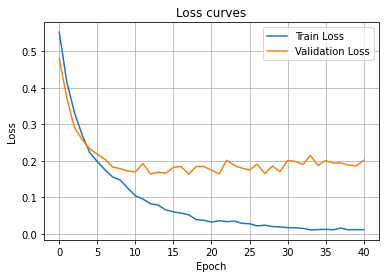

In [16]:
plt.plot(vgg_train_loss, label='Train Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

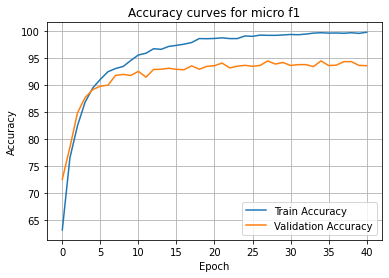

In [17]:
a = []
b = []
for result in vgg_train_result:
  a.append(result["micro_f1"]*100)

for result in vgg_val_result:
  b.append(result["micro_f1"]*100)

plt.plot(a, label='Train Accuracy')
plt.plot(b, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy curves for micro f1")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

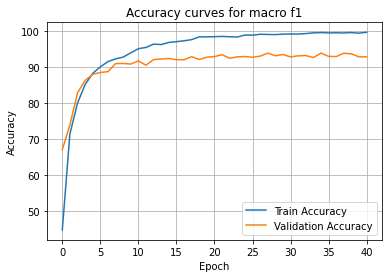

In [18]:
a = []
b = []
for result in vgg_train_result:
  a.append(result["macro_f1"]*100)

for result in vgg_val_result:
  b.append(result["macro_f1"]*100)

plt.plot(a, label='Train Accuracy')
plt.plot(b, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy curves for macro f1")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

In [19]:
def test_model(test_dataloader, optimizer, criterion, net, threshold):
  test_outputs = []
  test_labels = []

  net.eval()

  for idx, data in enumerate(test_dataloader):
    img, label = data
    img = img.to(device)
    label = label.to(device)

    outputs = net(img)

    pred = outputs.data > threshold
    pred = pred.type(torch.float)
      
    test_outputs.extend(pred.cpu().to(torch.int).numpy())
    test_labels.extend(label.cpu().to(torch.int).numpy())

  test_result = calculate_metric(np.array(test_outputs), np.array(test_labels))

  return np.asarray(test_outputs), np.asarray(test_labels), test_result 

In [20]:
vgg_test_outputs, vgg_test_labels, vgg_test_result = test_model(test_dataloader, optimizer, criterion, train_ft, 0.5)

In [21]:
vgg_test_result

{'macro_f1': 0.9455819695271437, 'micro_f1': 0.9510682288077188}

In [22]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for idx in range(4):
    fpr[idx], tpr[idx], _ = roc_curve(vgg_test_labels[:, idx], vgg_test_outputs[:, idx])
    roc_auc[idx] = auc(fpr[idx], tpr[idx])

fpr["micro"], tpr["micro"], _ = roc_curve(vgg_test_labels.ravel(), vgg_test_outputs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


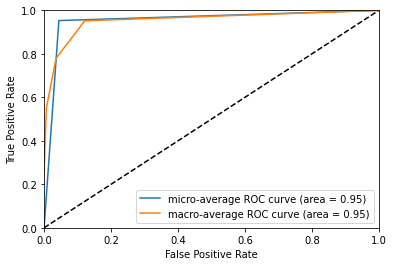

In [23]:
x = np.linspace(0,1)
y = x
plt.plot(x,y,linestyle="dashed",color='black')
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [24]:
final_df = pd.DataFrame(data=vgg_train_loss, columns=["train_loss"])
final_df["train_result_micro"] = [data['micro_f1'] for data in vgg_train_result]
final_df["train_result_macro"] = [data['macro_f1'] for data in vgg_train_result]
final_df["val_loss"] = vgg_val_loss
final_df["val_result_micro"] = [data['micro_f1'] for data in vgg_val_result]
final_df["val_result_macro"] = [data['macro_f1'] for data in vgg_val_result]

final_df.to_csv("/content/drive/MyDrive/Output/vgg_train",index=False)

In [25]:
final_df_train = pd.DataFrame(data=vgg_test_labels, columns=["label1","label2","label3","label4"])
final_df_train["pred1"] = vgg_test_outputs[:,0]
final_df_train["pred2"] = vgg_test_outputs[:,1]
final_df_train["pred3"] = vgg_test_outputs[:,2]
final_df_train["pred4"] = vgg_test_outputs[:,3]

final_df_train.to_csv("/content/drive/MyDrive/Output/vgg_test",index=False)